# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy import stats

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [8]:
missing_values = df.isnull().sum()
print(missing_values)

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
num            0
flag_doente    0
dtype: int64


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [10]:
def bivariada(df, resposta, explicativa):
    # Contagem de saudáveis e doentes por variável explicativa
    bivariada_df = df.groupby(explicativa)[resposta].agg(
        saudaveis=lambda x: (x == 0).sum(),
        doentes=lambda x: (x == 1).sum()
    ).reset_index()

    # Total de indivíduos por variável explicativa
    bivariada_df['total'] = bivariada_df['saudaveis'] + bivariada_df['doentes']

    # Quantidade média de doentes
    bivariada_df['media_doentes'] = bivariada_df['doentes'] / bivariada_df['total']

    # Cálculo dos Odds
    bivariada_df['odds'] = bivariada_df['doentes'] / bivariada_df['saudaveis']

    # Odds ratio usando o total como referência
    odds_total = df[resposta].mean() / (1 - df[resposta].mean())
    bivariada_df['odds_ratio'] = bivariada_df['odds'] / odds_total

    # Logito (Log dos Odds)
    bivariada_df['logito'] = np.log(bivariada_df['odds'])

    # Weight of Evidence (WOE - Log do Odds Ratio)
    bivariada_df['woe'] = np.log(bivariada_df['odds_ratio'])

    return bivariada_df

In [12]:
# Analisando a variável sex
bivariada_sex = bivariada(df, 'flag_doente', 'sex')
print("Bivariada para a variável 'sex':")
print(bivariada_sex)

# Analisando a variável cp (tipo de dor no peito)
bivariada_cp = bivariada(df, 'flag_doente', 'cp')
print("\nBivariada para a variável 'cp':")
print(bivariada_cp)

# Analisando a variável fbs (nível de açúcar no sangue em jejum)
bivariada_fbs = bivariada(df, 'flag_doente', 'fbs')
print("\nBivariada para a variável 'fbs':")
print(bivariada_fbs)

Bivariada para a variável 'sex':
   sex  saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
0  0.0         72       25     97       0.257732  0.347222    0.409672   
1  1.0         92      114    206       0.553398  1.239130    1.461996   

    logito       woe  
0 -1.05779 -0.892398  
1  0.21441  0.379802  

Bivariada para a variável 'cp':
    cp  saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
0  1.0         16        7     23       0.304348  0.437500    0.516187   
1  2.0         41        9     50       0.180000  0.219512    0.258993   
2  3.0         68       18     86       0.209302  0.264706    0.312315   
3  4.0         39      105    144       0.729167  2.692308    3.176536   

     logito       woe  
0 -0.826679 -0.661286  
1 -1.516347 -1.350955  
2 -1.329136 -1.163743  
3  0.990399  1.155791  

Bivariada para a variável 'fbs':
   fbs  saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
0  0.0        141      117    258       0.4

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [21]:
def bivariada_continua(df, resposta, explicativa, num_categorias=5):
    # Categorizar a variável quantitativa em grupos
    df['grupo_' + explicativa] = pd.qcut(df[explicativa], q=num_categorias, labels=False)

    # Contagem de saudáveis e doentes por grupo da variável explicativa
    bivariada_df = df.groupby('grupo_' + explicativa)[resposta].agg(
        saudaveis=lambda x: (x == 0).sum(),
        doentes=lambda x: (x == 1).sum()
    ).reset_index()

    # Total de indivíduos por grupo
    bivariada_df['total'] = bivariada_df['saudaveis'] + bivariada_df['doentes']

    # Quantidade média de doentes
    bivariada_df['media_doentes'] = bivariada_df['doentes'] / bivariada_df['total']

    # Cálculo dos Odds
    bivariada_df['odds'] = bivariada_df['doentes'] / bivariada_df['saudaveis']

    # Odds ratio usando o total como referência
    odds_total = df[resposta].mean() / (1 - df[resposta].mean())
    bivariada_df['odds_ratio'] = bivariada_df['odds'] / odds_total

    # Logito (Log dos Odds)
    bivariada_df['logito'] = np.log(bivariada_df['odds'])

    # Weight of Evidence (WOE - Log do Odds Ratio)
    bivariada_df['woe'] = np.log(bivariada_df['odds_ratio'])

    # Valor médio da variável explicativa por grupo
    bivariada_df['media_' + explicativa] = df.groupby('grupo_' + explicativa)[explicativa].mean().reset_index(drop=True)

    return bivariada_df

In [23]:
# Analisando a variável age (idade) com 5 grupos (default)
bivariada_age = bivariada_continua(df, 'flag_doente', 'age')
print("Bivariada para a variável 'age' (5 grupos):")
print(bivariada_age)

# Analisando a variável age (idade) com 3 grupos
bivariada_age_3_grupos = bivariada_continua(df, 'flag_doente', 'age', num_categorias=3)
print("\nBivariada para a variável 'age' (3 grupos):")
print(bivariada_age_3_grupos)

Bivariada para a variável 'age' (5 grupos):
   grupo_age  saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
0          0         47       16     63       0.253968  0.340426    0.401653   
1          1         42       22     64       0.343750  0.523810    0.618020   
2          2         32       39     71       0.549296  1.218750    1.437950   
3          3         13       32     45       0.711111  2.461538    2.904261   
4          4         30       30     60       0.500000  1.000000    1.179856   

     logito       woe  media_age  
0 -1.077559 -0.912166  41.222222  
1 -0.646627 -0.481235  50.000000  
2  0.197826  0.363218  56.211268  
3  0.900787  1.066179  60.355556  
4  0.000000  0.165392  66.516667  

Bivariada para a variável 'age' (3 grupos):
   grupo_age  saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
0          0         74       32    106       0.301887  0.432432    0.510208   
1          1         52       54    106       0.509434  1.03

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [27]:
# Modelo de regressão logística com as variáveis 'sex', 'cp', 'trestbps' e 'age'
modelo_logistico = smf.logit(formula='flag_doente ~ C(sex) + C(cp) + trestbps + age', data=df).fit()

# Exibir o resumo do modelo
print(modelo_logistico.summary())

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.3097
Time:                        13:43:45   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.

<span style="color:red">O P-value do cp não é significativo com as variáveis em dummies.</span>


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

   grupo_prob  prob_predita_media  taxa_eventos_observada
0           0            0.072008                0.080645
1           1            0.209626                0.152542
2           2            0.435175                0.483871
3           3            0.708861                0.762712
4           4            0.874819                0.819672


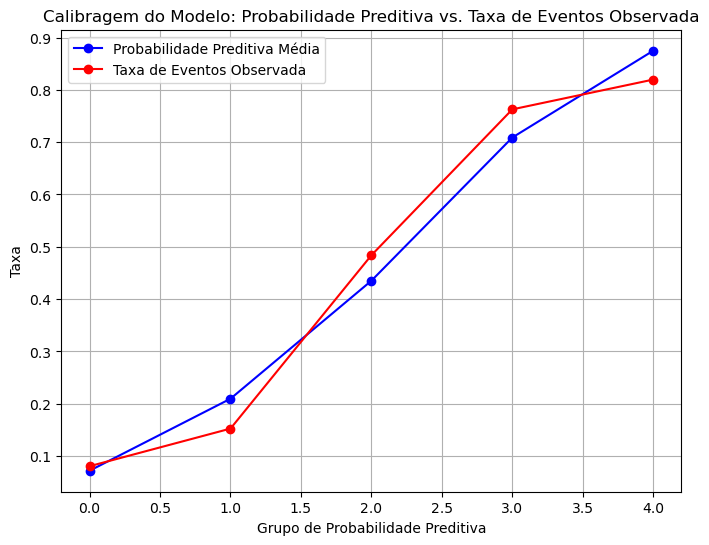

In [39]:
# Calculando a probabilidade de evento predita pelo modelo
df['prob_predita'] = modelo_logistico.predict(df)

# Visualizando as primeiras linhas com a probabilidade predita
df[['flag_doente', 'prob_predita']].head()

# Categorizar as probabilidades preditas em 5 grupos (quantis)
df['grupo_prob'] = pd.qcut(df['prob_predita'], q=5, labels=False)

# Visualizando as primeiras linhas com o grupo de probabilidade
df[['prob_predita', 'grupo_prob']].head()

# Calcular a probabilidade predita média e a taxa de eventos observada por grupo
calibragem_df = df.groupby('grupo_prob').agg(
    prob_predita_media=('prob_predita', 'mean'),
    taxa_eventos_observada=('flag_doente', 'mean')
).reset_index()

# Visualizando a tabela de calibragem
print(calibragem_df)

# Comparação gráfica entre probabilidade predita e taxa de eventos observada
plt.figure(figsize=(8, 6))

# Linha para a probabilidade predita média
plt.plot(calibragem_df['grupo_prob'], calibragem_df['prob_predita_media'], marker='o', label='Probabilidade Preditiva Média', color='blue')

# Linha para a taxa de eventos observada
plt.plot(calibragem_df['grupo_prob'], calibragem_df['taxa_eventos_observada'], marker='o', label='Taxa de Eventos Observada', color='red')

# Título e eixos
plt.title('Calibragem do Modelo: Probabilidade Preditiva vs. Taxa de Eventos Observada')
plt.xlabel('Grupo de Probabilidade Preditiva')
plt.ylabel('Taxa')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [44]:
# Prevendo o rótulo de doença com base em um limiar de 0.5
df['predito'] = (df['prob_predita'] >= 0.5).astype(int)

# Calculando a acurácia
acuracia = accuracy_score(df['flag_doente'], df['predito'])
print(f'Acurácia: {acuracia:.4f}')

# Calculando o AUC (Área sob a curva ROC)
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])

# Calculando o GINI (GINI = 2*AUC - 1)
gini = 2 * auc - 1
print(f'GINI: {gini:.4f}')

# Separar os dados de probabilidade predita para doentes e saudáveis
doentes = df[df['flag_doente'] == 1]['prob_predita']
saudaveis = df[df['flag_doente'] == 0]['prob_predita']

# Calculando o KS (Kolmogorov-Smirnov)
ks_stat, p_value = stats.ks_2samp(doentes, saudaveis)
print(f'KS: {ks_stat:.4f}')

Acurácia: 0.7954
GINI: 0.7039
KS: 0.5930


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [50]:
# Preparando as variáveis
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

# Adicionando uma constante para o modelo
X = sm.add_constant(X)

# Ajustando o modelo de regressão logística
modelo = sm.Logit(y, X)
resultado = modelo.fit()

# Resumo dos resultados
print(resultado.summary())

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.2605
Time:                        14:34:07   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.